In [53]:
%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from src.data.news.coverage_filter import filter_protests
from src.data.protests.random import get_random_events

random_events = get_random_events(20, seed=3)
random_events = filter_protests(random_events, source="mediacloud")

In [55]:
from src.models.synthetic_region import (
    _Lasso,
    evaluate_multiple_protests,
    predict_with_lasso,
    train_test_split,
)


def evaluate(method, min_count=0.1):
    metrics, df, agg_df = evaluate_multiple_protests(
        "klima*",
        random_events,
        source="mediacloud",
        data_kwargs=dict(
            n_days_train=7 * 4,
            n_days_predict=7 * 2,
            n_days_protest_free_pre=0,
            n_days_protest_free_post=0,
            min_control_regions=1,
            min_count=min_count,
        ),
        method_kwargs=dict(
            method=method,
        ),
    )
    return metrics, df, agg_df

In [56]:
metrics, _, _ = evaluate(predict_with_lasso)

  0%|          | 0/16 [00:00<?, ?it/s]

In [57]:
mse = [m["mse"] for m in metrics]

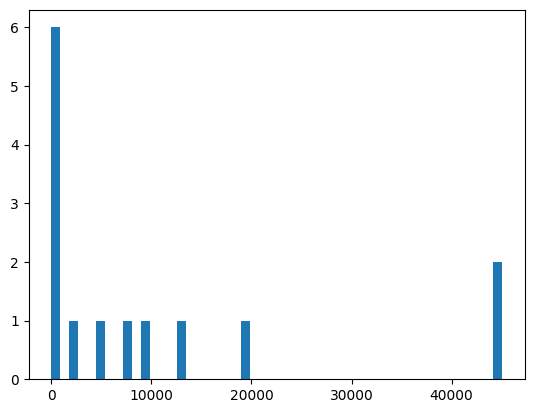

10409.688822990152

In [58]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(mse, bins=50)
plt.show()
np.mean(mse)

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def predict_with_forecaster(df, protest_region, protest_date, normalize):
    """
    df: df in pivoted form, with regions as columns and dates as index
    """
    X_train, Y_train, X_test, Y_test = train_test_split(
        df, protest_region, protest_date, normalize
    )
    forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=123), lags=15
    )
    forecaster.fit(Y_train)
    Y_pred = forecaster.predict(steps=len(Y_test))
    mse = mean_squared_error(Y_test, Y_pred)
    Y_pred_all = pd.concat([Y_train, Y_pred])
    return mse, Y_pred_all, forecaster

In [60]:
metrics, dfs, agg_df = evaluate(predict_with_forecaster)

  0%|          | 0/16 [00:00<?, ?it/s]

1935.829878095238

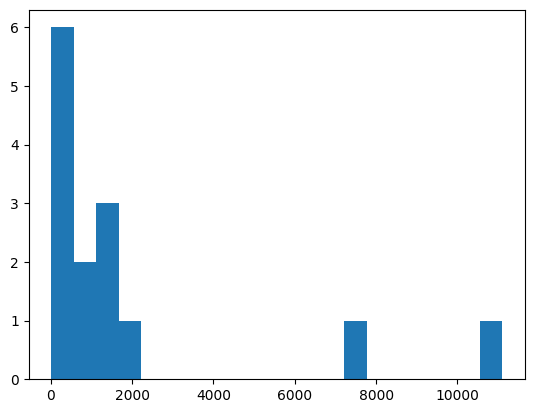

In [61]:
import matplotlib.pyplot as plt

mse = [m["mse"] for m in metrics]
plt.hist(mse, bins=20)
np.mean(mse)

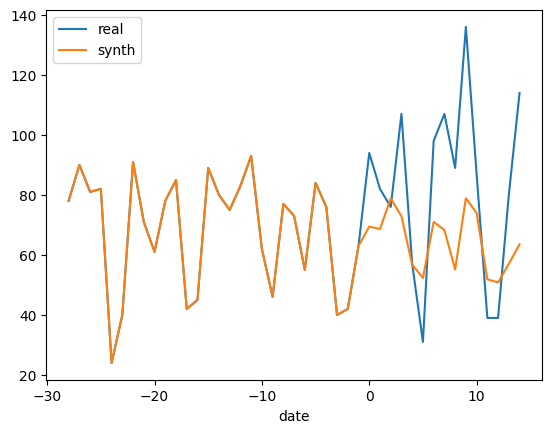

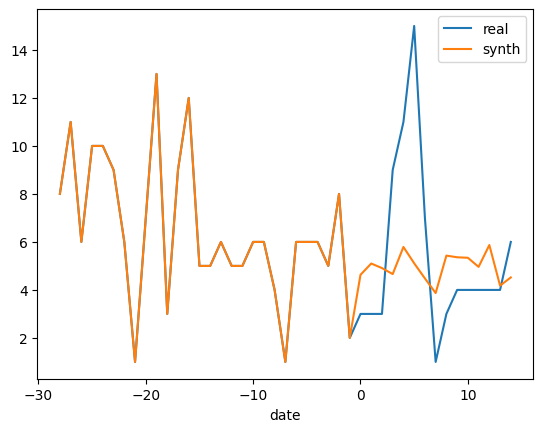

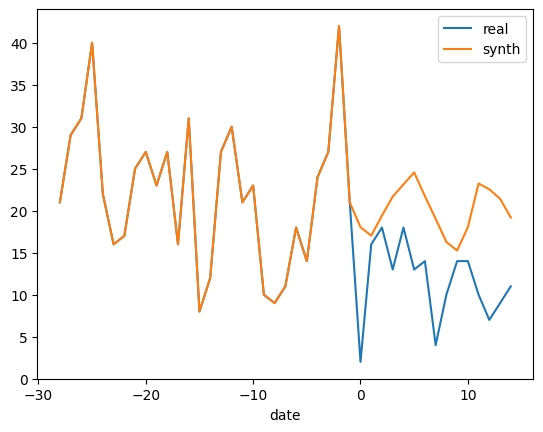

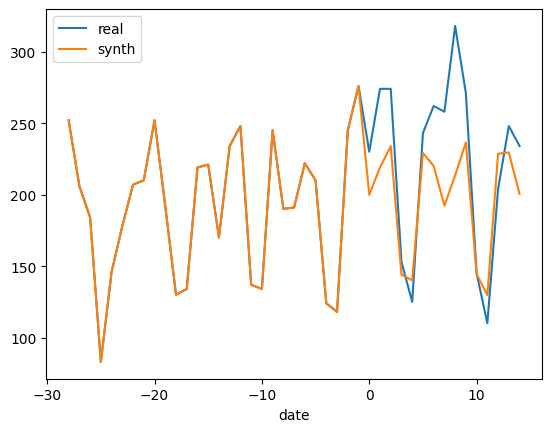

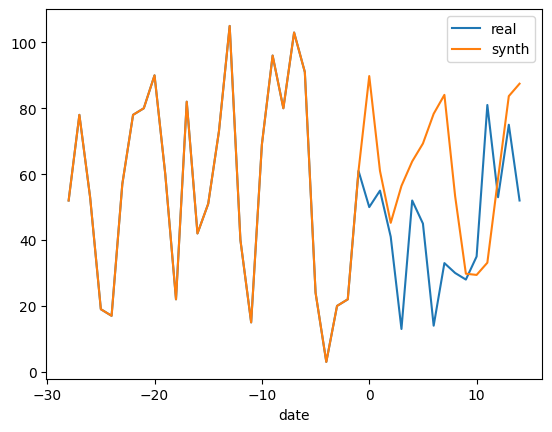

In [62]:
for df in dfs[:5]:
    fig, ax = plt.subplots()
    df.plot(x="date", y=["real", "synth"], ax=ax)
    plt.show()

In [63]:
def predict_with_forecaster(df, protest_region, protest_date, normalize):
    """
    df: df in pivoted form, with regions as columns and dates as index
    """
    X_train, Y_train, X_test, Y_test = train_test_split(
        df, protest_region, protest_date, normalize
    )
    forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=123), lags=7 * 4
    )
    forecaster.fit(y=Y_train, exog=X_train)
    Y_pred = forecaster.predict(steps=len(Y_test), exog=X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    Y_pred_all = pd.concat([Y_train, Y_pred])
    return mse, Y_pred_all, forecaster

In [ ]:
metrics, dfs, agg_df = evaluate(predict_with_forecaster)

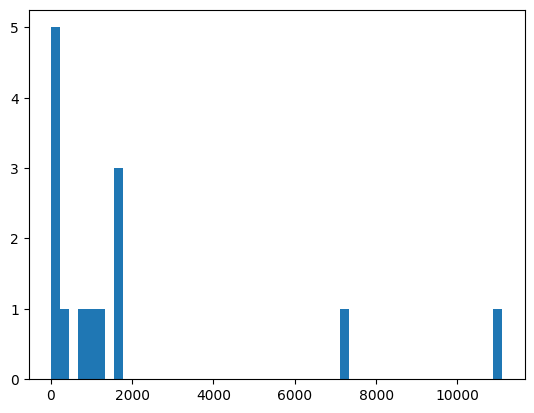

1935.829878095238

In [ ]:
import matplotlib.pyplot as plt

mse = [m["mse"] for m in metrics]
plt.hist(mse, bins=50)
plt.show()
np.mean(mse)

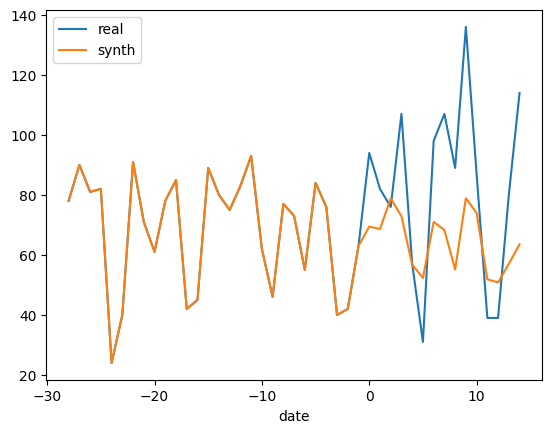

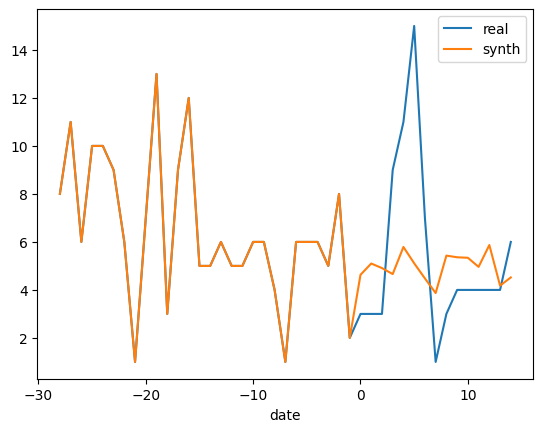

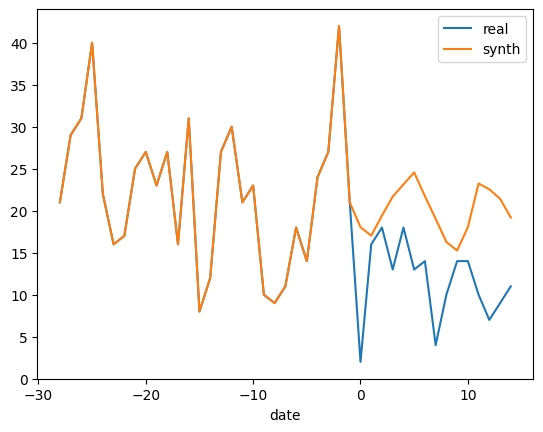

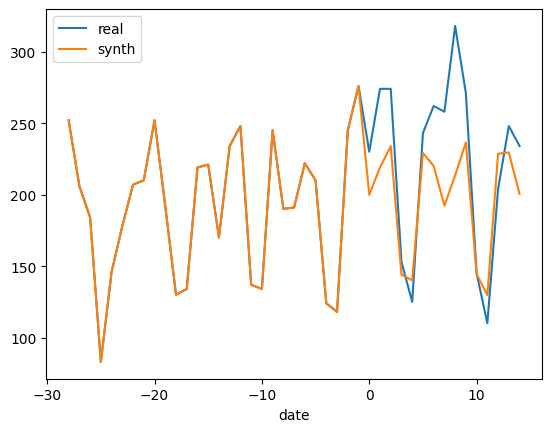

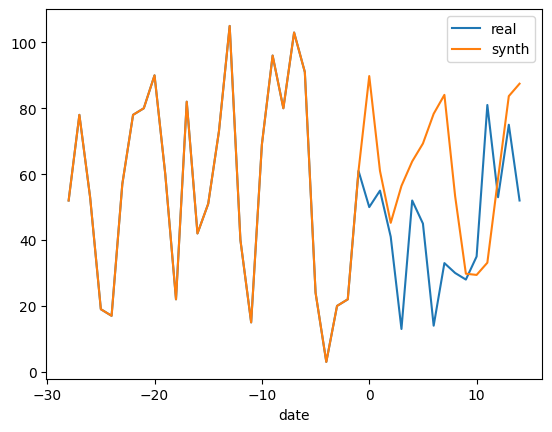

In [ ]:
for df in dfs[:5]:
    fig, ax = plt.subplots()
    df.plot(x="date", y=["real", "synth"], ax=ax)
    plt.show()

In [ ]:
metrics[0]["model"].get_feature_importance()

,feature,importance
0,lag_1,0.015674
1,lag_2,0.044409
2,lag_3,0.030722
3,lag_4,0.019581
4,lag_5,0.029114
5,lag_6,0.008221
6,lag_7,0.187811
7,lag_8,0.016993
8,lag_9,0.025768
9,lag_10,0.026328


In [65]:
from sklearn.linear_model import Lasso, LinearRegression


def predict_with_forecaster(df, protest_region, protest_date, normalize):
    """
    df: df in pivoted form, with regions as columns and dates as index
    """
    X_train, Y_train, X_test, Y_test = train_test_split(
        df, protest_region, protest_date, normalize
    )
    forecaster = ForecasterAutoreg(
        regressor=_Lasso(
            random_state=123, alpha=0.1, positive=True, fit_intercept=False
        ),
        #  regressor = LinearRegression(positive=True, fit_intercept=False),
        # regressor = RandomForestRegressor(random_state=123),
        lags=1,
    )
    forecaster.fit(y=Y_train, exog=X_train)
    Y_pred = forecaster.predict(steps=len(Y_test), exog=X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    Y_pred_all = pd.concat([Y_train, Y_pred])
    return mse, Y_pred_all, forecaster

In [ ]:
metrics, dfs, agg_df = evaluate(predict_with_forecaster)

  0%|          | 0/16 [00:00<?, ?it/s]

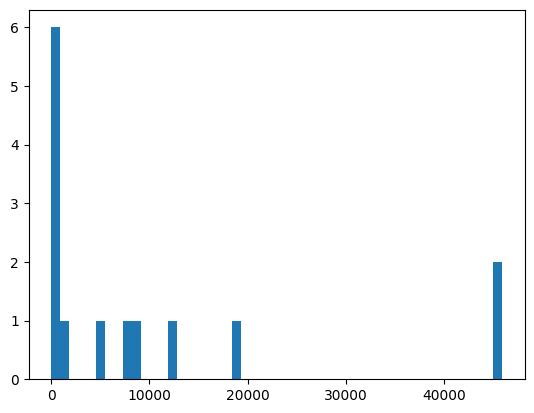

10451.70546934174

In [ ]:
import matplotlib.pyplot as plt

mse = [m["mse"] for m in metrics]
plt.hist(mse, bins=50)
plt.show()
np.mean(mse)

In [ ]:
metrics[5]["model"].get_feature_importance()

,feature,importance
0,lag_1,0.000000
1,Bayern,0.000000
2,Berlin,0.000000
3,Brandenburg,0.238693
4,Bremen,0.203230
5,Hamburg,0.000000
6,Hessen,0.000000
7,Nordrhein-Westfalen,0.000000
8,Rheinland-Pfalz,0.000000
9,Saarland,0.040232


<Axes: >

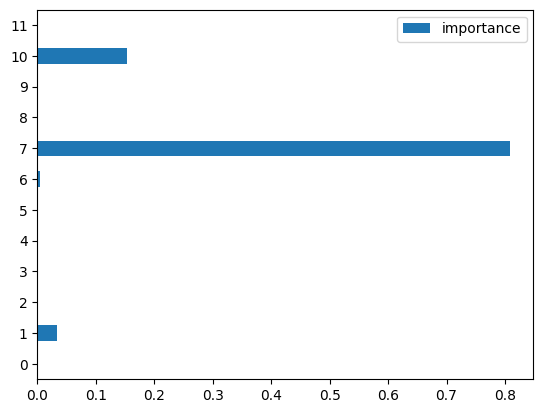

In [ ]:
metrics[7]["model"].get_feature_importance().plot.barh()

There is too much randomness in the events! Presumably due to the different coverage of different regions.


In [ ]:
from collections import defaultdict

from src.data.news.coverage_filter import filter_protests
from src.data.protests.random import get_random_events

mses = defaultdict(list)
for min_count in [0.1, 1, 2, 3, 4, 6, 8, 10, 15, 20]:
    for seed in range(10):
        random_events = get_random_events(20, seed=seed)
        random_events = filter_protests(random_events, source="mediacloud")
        metrics, dfs, agg_df = evaluate(predict_with_lasso, min_count=min_count)
        mses[min_count].append(
            {
                "mean_mse": np.mean([m["mse"] for m in metrics]),
                "n": len(metrics),
                "p": len(metrics) / len(random_events),
            }
        )

In [ ]:
{
    k: (
        np.mean([a["mean_mse"] for a in v]),
        np.std([a["mean_mse"] for a in v]),
        np.mean([a["n"] for a in v]),
        np.mean([a["p"] for a in v]),
    )
    for k, v in mses.items()
}

{0.1: (4047.5266146730114, 2711.175817111053, 13.0, 0.8289465786314526)}

With labels:


In [ ]:
{
    k: {
        "mean mses": np.mean([a["mean_mse"] for a in v]),
        "std of mean mses": np.std([a["mean_mse"] for a in v]),
        "mean number of evaluated protests": np.mean([a["n"] for a in v]),
        "mean proportion of evaluated protests": np.mean([a["p"] for a in v]),
    }
    for k, v in mses.items()
}

{0.1: {'mean mses': 0.2802185268169165,
  'std of mean mses': 0.1986098484151064,
  'mean number of evaluated protests': 13.4,
  'mean proportion of evaluated protests': 0.8497070494864613},
 1: {'mean mses': 0.14472663738165256,
  'std of mean mses': 0.0721972743333614,
  'mean number of evaluated protests': 12.6,
  'mean proportion of evaluated protests': 0.8021090102707749},
 2: {'mean mses': 0.1315051421758226,
  'std of mean mses': 0.05702934193061505,
  'mean number of evaluated protests': 12.4,
  'mean proportion of evaluated protests': 0.7895599906629318},
 3: {'mean mses': 0.10902461163753771,
  'std of mean mses': 0.03246264608965154,
  'mean number of evaluated protests': 11.7,
  'mean proportion of evaluated protests': 0.7430625583566759},
 4: {'mean mses': 0.10248247840828843,
  'std of mean mses': 0.03212906940611994,
  'mean number of evaluated protests': 11.4,
  'mean proportion of evaluated protests': 0.7236974789915966},
 6: {'mean mses': 0.1034199403351053,
  'std of

3 seems to be a good threshold for stable results. (Mean number of daily article counts in each region should be 3 at least.)


In [68]:
def evaluate(method, n_days_train):
    metrics, df, agg_df = evaluate_multiple_protests(
        "klima*",
        random_events,
        source="mediacloud",
        data_kwargs=dict(
            n_days_train=n_days_train,
            n_days_predict=7 * 2,
            n_days_protest_free_pre=0,
            n_days_protest_free_post=0,
            min_control_regions=1,
            min_count=3,  # <==
        ),
        method_kwargs=dict(
            method=method,
        ),
    )
    return metrics, df, agg_df

In [ ]:
random_events = get_random_events(100, seed=0)
random_events = filter_protests(random_events, source="mediacloud")

In [ ]:
metrics, dfs, agg_df = evaluate(predict_with_lasso, n_days_train=7 * 4 * 3)
mses = [m["mse"] for m in metrics]
np.mean(mses), np.std(mses)

  0%|          | 0/80 [00:00<?, ?it/s]

(2298.5936132149636, 4697.836716456597)

In [ ]:
metrics, dfs, agg_df = evaluate(predict_with_forecaster, n_days_train=7 * 4 * 3)
mses = [m["mse"] for m in metrics]
np.mean(mses), np.std(mses)

  0%|          | 0/80 [00:00<?, ?it/s]

(2330.894558507027, 4830.339469922961)

In [ ]:
from functools import partial

from sklearn.linear_model import Lasso, LinearRegression


def predict_with_forecaster(df, protest_region, protest_date, lags, regressor):
    """
    df: df in pivoted form, with regions as columns and dates as index
    """
    X_train, Y_train, X_test, Y_test = train_test_split(
        df, protest_region, protest_date
    )
    forecaster = ForecasterAutoreg(
        regressor=regressor,
        lags=lags,
    )
    forecaster.fit(y=Y_train, exog=X_train)
    Y_pred = forecaster.predict(steps=len(Y_test), exog=X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    Y_pred_all = pd.concat([Y_train, Y_pred])
    return mse, Y_pred_all, forecaster


metrics, dfs, agg_df = evaluate(
    partial(
        predict_with_forecaster,
        lags=14,
        regressor=LinearRegression(positive=True, fit_intercept=False),
    ),
    n_days_train=7 * 4 * 3,
)
mses = [m["mse"] for m in metrics]
np.mean(mses), np.std(mses)

  0%|          | 0/80 [00:00<?, ?it/s]

(128.9175458963782, 195.8336421041822)

In [ ]:
from tqdm.auto import tqdm

mses = []
for n_days_train in tqdm([7 * 4, 7 * 4 * 3, 7 * 4 * 6, 7 * 4 * 12, None]):
    for lag in [7, 7 * 2, 7 * 4, 7 * 4 * 3, 7 * 4 * 6, 7 * 4 * 12]:
        if n_days_train is not None and lag >= n_days_train:
            continue
        metrics, dfs, agg_df = evaluate(
            partial(
                predict_with_forecaster,
                lags=lag,
                regressor=LinearRegression(positive=True, fit_intercept=False),
            ),
            n_days_train=n_days_train,
        )
        mses.append(
            {
                "n_days_train": n_days_train,
                "lag": lag,
                "mean_mse": np.mean([m["mse"] for m in metrics]),
                "std_mse": np.std([m["mse"] for m in metrics]),
            }
        )
mse_df = pd.DataFrame(mses)

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_62732/2998920556.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  mse_df.pivot("lag", "n_days_train", "mean_mse"),


<Axes: xlabel='n_days_train', ylabel='lag'>

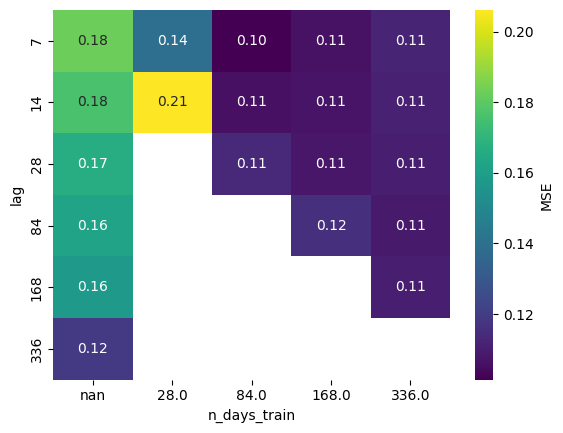

In [ ]:
# heatmap
import seaborn as sns

sns.heatmap(
    mse_df.pivot("lag", "n_days_train", "mean_mse"),
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "MSE"},
)

In [ ]:
from tqdm.auto import tqdm

mses = []
for n_days_train in tqdm([7 * 4, 7 * 4 * 3, 7 * 4 * 6, 7 * 4 * 12, None]):
    for lag in [7, 7 * 2, 7 * 4, 7 * 4 * 3, 7 * 4 * 6, 7 * 4 * 12]:
        if n_days_train is not None and lag >= n_days_train:
            continue
        metrics, dfs, agg_df = evaluate(
            partial(
                predict_with_forecaster,
                lags=lag,
                regressor=Lasso(positive=True, fit_intercept=False, alpha=0.1),
            ),
            n_days_train=n_days_train,
        )
        mses.append(
            {
                "n_days_train": n_days_train,
                "lag": lag,
                "mean_mse": np.mean([m["mse"] for m in metrics]),
                "std_mse": np.std([m["mse"] for m in metrics]),
            }
        )
mse_df = pd.DataFrame(mses)

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_62732/3568070177.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  mse_df.pivot("lag", "n_days_train", "mean_mse"),


<Axes: xlabel='n_days_train', ylabel='lag'>

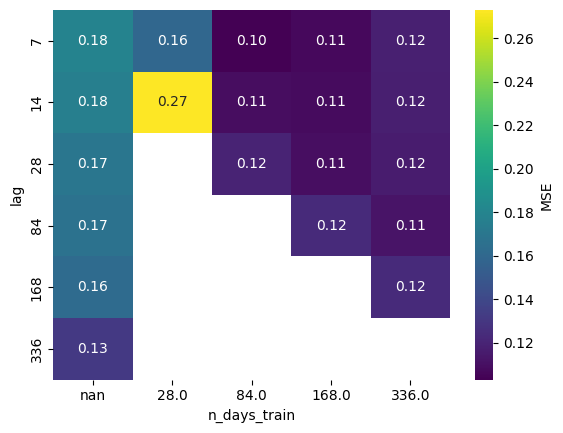

In [ ]:
import seaborn as sns

sns.heatmap(
    mse_df.pivot("lag", "n_days_train", "mean_mse"),
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "MSE"},
)

In [ ]:
mses = []
for n_days_train in tqdm([7 * 4, 7 * 4 * 3, 7 * 4 * 6, 7 * 4 * 12, None]):
    for lag in [7, 7 * 2, 7 * 4, 7 * 4 * 3, 7 * 4 * 6, 7 * 4 * 12]:
        if n_days_train is not None and lag >= n_days_train:
            continue
        metrics, dfs, agg_df = evaluate(
            partial(
                predict_with_forecaster,
                lags=lag,
                regressor=RandomForestRegressor(random_state=123),
            ),
            n_days_train=n_days_train,
        )
        mses.append(
            {
                "n_days_train": n_days_train,
                "lag": lag,
                "mean_mse": np.mean([m["mse"] for m in metrics]),
                "std_mse": np.std([m["mse"] for m in metrics]),
            }
        )
mse_df = pd.DataFrame(mses)

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_62732/1155279579.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  mse_df.pivot("lag", "n_days_train", "mean_mse"),


<Axes: xlabel='n_days_train', ylabel='lag'>

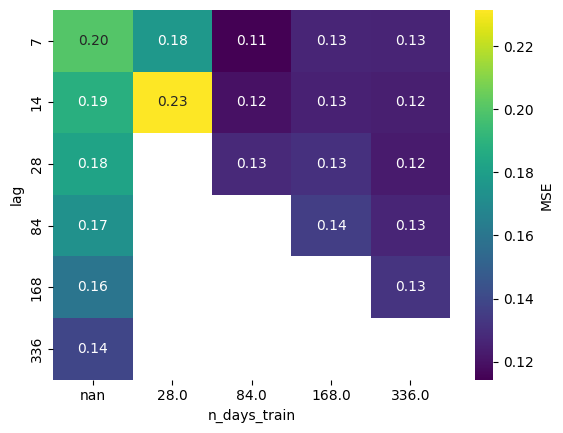

In [ ]:
sns.heatmap(
    mse_df.pivot("lag", "n_days_train", "mean_mse"),
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "MSE"},
)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

mses = []
for n_days_train in tqdm([7 * 4, 7 * 4 * 3, 7 * 4 * 6, 7 * 4 * 12, None]):
    for lag in [7, 7 * 2, 7 * 4, 7 * 4 * 3, 7 * 4 * 6, 7 * 4 * 12]:
        if n_days_train is not None and lag >= n_days_train:
            continue
        metrics, dfs, agg_df = evaluate(
            partial(
                predict_with_forecaster,
                lags=lag,
                regressor=GradientBoostingRegressor(random_state=123),
            ),
            n_days_train=n_days_train,
        )
        mses.append(
            {
                "n_days_train": n_days_train,
                "lag": lag,
                "mean_mse": np.mean([m["mse"] for m in metrics]),
                "std_mse": np.std([m["mse"] for m in metrics]),
            }
        )
mse_df = pd.DataFrame(mses)

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_62732/1155279579.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  mse_df.pivot("lag", "n_days_train", "mean_mse"),


<Axes: xlabel='n_days_train', ylabel='lag'>

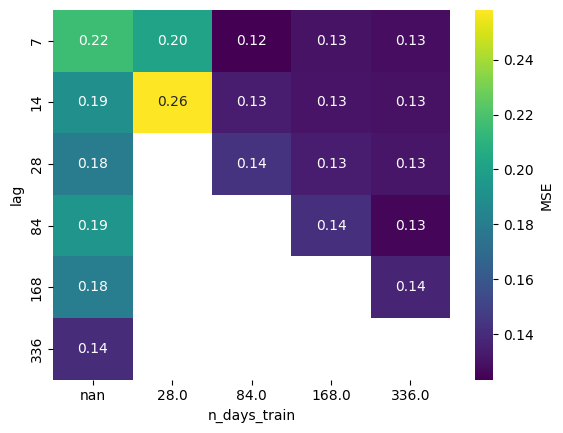

In [ ]:
sns.heatmap(
    mse_df.pivot("lag", "n_days_train", "mean_mse"),
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "MSE"},
)

In [ ]:
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect


def predict_with_direct_forecaster(df, protest_region, protest_date, lags, regressor):
    """
    df: df in pivoted form, with regions as columns and dates as index
    """
    X_train, Y_train, X_test, Y_test = train_test_split(
        df, protest_region, protest_date
    )
    forecaster = ForecasterAutoregDirect(regressor=regressor, lags=lags, steps=15)
    forecaster.fit(y=Y_train, exog=X_train)
    Y_pred = forecaster.predict(steps=len(Y_test), exog=X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    Y_pred_all = pd.concat([Y_train, Y_pred])
    return mse, Y_pred_all, forecaster

In [ ]:
mses = []
for n_days_train in tqdm([7 * 4 * 3, 7 * 4 * 6]):
    for lag in [7, 7 * 2, 7 * 4]:
        if n_days_train is not None and lag >= n_days_train:
            continue
        metrics, dfs, agg_df = evaluate(
            partial(
                predict_with_direct_forecaster,
                lags=lag,
                regressor=Lasso(positive=True, fit_intercept=False, alpha=0.1),
            ),
            n_days_train=n_days_train,
        )
        mses.append(
            {
                "n_days_train": n_days_train,
                "lag": lag,
                "mean_mse": np.mean([m["mse"] for m in metrics]),
                "std_mse": np.std([m["mse"] for m in metrics]),
            }
        )
mse_df = pd.DataFrame(mses)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_62732/1155279579.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  mse_df.pivot("lag", "n_days_train", "mean_mse"),


<Axes: xlabel='n_days_train', ylabel='lag'>

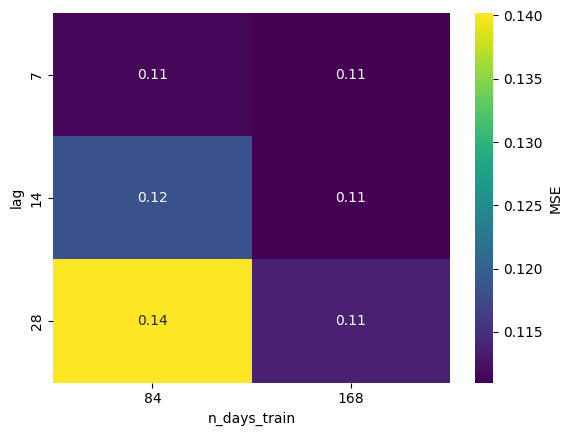

In [ ]:
sns.heatmap(
    mse_df.pivot("lag", "n_days_train", "mean_mse"),
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "MSE"},
)

So the forecaster is not better than simple linear or Lasso regression.

In [69]:
random_events = get_random_events(2_000, seed=0)
random_events = filter_protests(random_events, source="mediacloud")

In [70]:
metrics, dfs, agg_df = evaluate(predict_with_lasso, n_days_train=None)

  0%|          | 0/1605 [00:00<?, ?it/s]

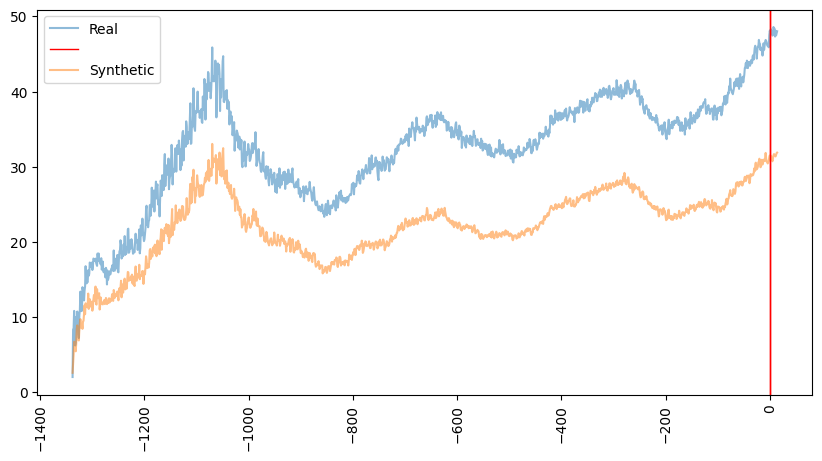

In [71]:
from src.data.discourse.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 5))
plot_coverage_sequence(agg_df.rename(columns={"real": "count"}), ax=ax, protest_date=0)
plot_coverage_sequence(agg_df.rename(columns={"synth": "count"}), ax=ax, protest_date=0)
ax.legend(["Real", "", "Synthetic"])

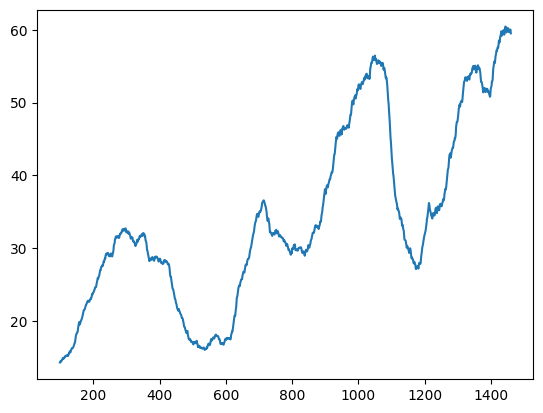

In [ ]:
from datetime import date

from src.models.synthetic_region import get_regional_count_df

df = get_regional_count_df(
    "klima*", "Berlin", date(2019, 1, 1), date(2022, 12, 31), source="mediacloud"
)
plt.plot(df["count"].rolling(100).mean())

In [ ]:
from src.models.synthetic_region import predict_with_random_forest

metrics, dfs, agg_df = evaluate(predict_with_random_forest, n_days_train=7 * 4 * 12)

  0%|          | 0/1605 [00:00<?, ?it/s]

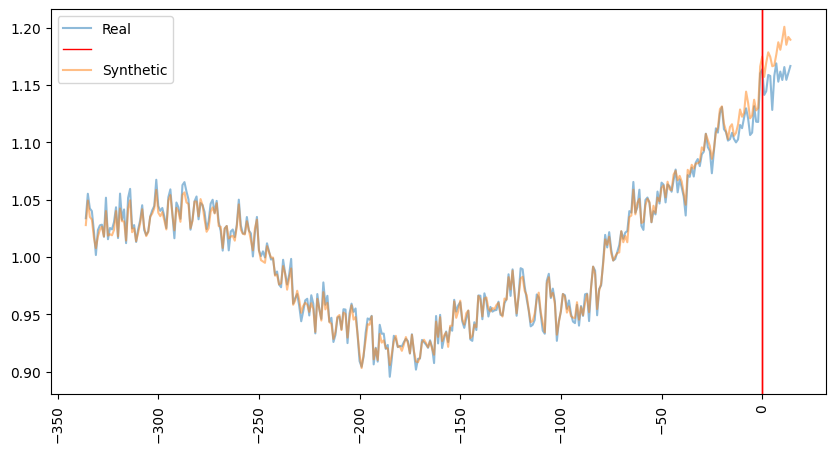

In [ ]:
from src.data.discourse.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 5))
plot_coverage_sequence(agg_df.rename(columns={"real": "count"}), ax=ax, protest_date=0)
plot_coverage_sequence(agg_df.rename(columns={"synth": "count"}), ax=ax, protest_date=0)
ax.legend(["Real", "", "Synthetic"])

In [ ]:
metrics, dfs, agg_df = evaluate(
    partial(
        predict_with_forecaster,
        lags=14,
        regressor=LinearRegression(positive=True, fit_intercept=False),
    ),
    n_days_train=None,
)

  0%|          | 0/1605 [00:00<?, ?it/s]

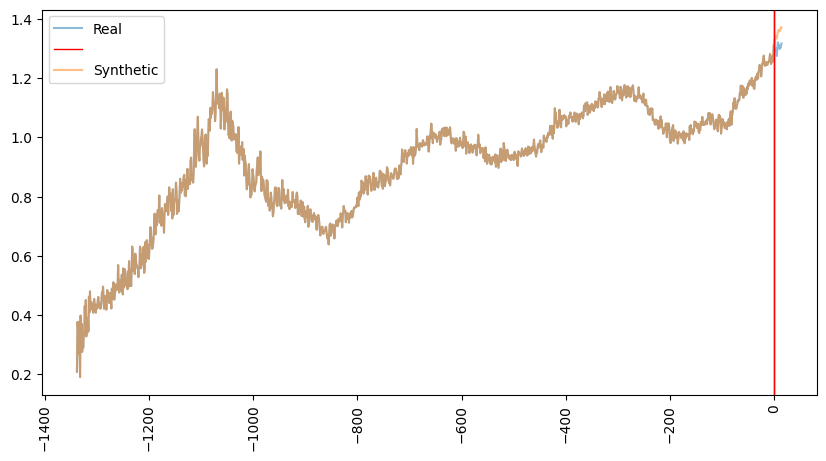

In [ ]:
from src.data.discourse.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 5))
plot_coverage_sequence(agg_df.rename(columns={"real": "count"}), ax=ax, protest_date=0)
plot_coverage_sequence(agg_df.rename(columns={"synth": "count"}), ax=ax, protest_date=0)
ax.legend(["Real", "", "Synthetic"])

In [ ]:
from src.models.synthetic_region import predict_with_model


def predict_with_linear_regression_(df, protest_region, protest_date, positive=True):
    # unconstrained linear regression with intercept
    return predict_with_model(
        df,
        protest_region,
        protest_date,
        LinearRegression(),
    )


metrics, dfs, agg_df = evaluate(
    method=predict_with_linear_regression_, n_days_train=None
)

  0%|          | 0/161 [00:00<?, ?it/s]

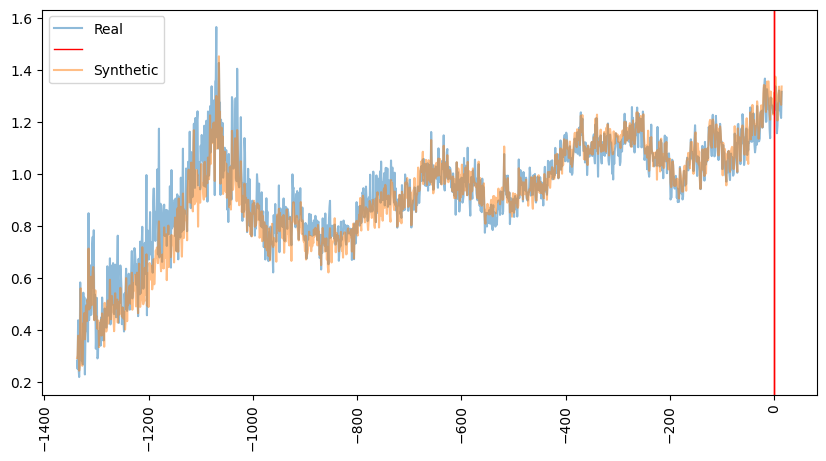

In [ ]:
from src.data.discourse.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 5))
plot_coverage_sequence(agg_df.rename(columns={"real": "count"}), ax=ax, protest_date=0)
plot_coverage_sequence(agg_df.rename(columns={"synth": "count"}), ax=ax, protest_date=0)
ax.legend(["Real", "", "Synthetic"])

In [ ]:
from sklearn.linear_model import PoissonRegressor

from src.models.synthetic_region import evaluate_multiple_protests, predict_with_model


def predict_with_poisson_regression(df, protest_region, protest_date):
    return predict_with_model(
        df,
        protest_region,
        protest_date,
        PoissonRegressor(),
    )


metrics, dfs, agg_df = evaluate(
    method=predict_with_poisson_regression, n_days_train=None
)

  0%|          | 0/16 [00:00<?, ?it/s]

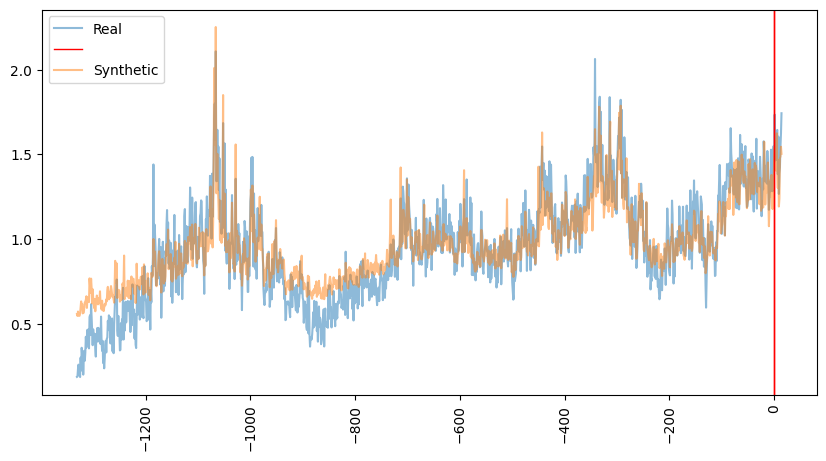

In [ ]:
import matplotlib.pyplot as plt

from src.data.discourse.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 5))
plot_coverage_sequence(agg_df.rename(columns={"real": "count"}), ax=ax, protest_date=0)
plot_coverage_sequence(agg_df.rename(columns={"synth": "count"}), ax=ax, protest_date=0)
ax.legend(["Real", "", "Synthetic"])

There is significant bias, independent of the method. The linear regression assumptions seem not to hold over large time periods, and nonlinear models and recursive prediction do not fix this.

Maybe smaller training windows can reduce this bias sufficiently near to 0?

In [ ]:
from src.data.discourse.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 5))
plot_coverage_sequence(agg_df.rename(columns={"real": "count"}), ax=ax, protest_date=0)
plot_coverage_sequence(agg_df.rename(columns={"synth": "count"}), ax=ax, protest_date=0)
ax.legend(["Real", "", "Synthetic"])

In [ ]:
random_events = get_random_events(200, seed=0)
random_events = filter_protests(random_events, source="mediacloud")

In [ ]:
data = []
for n_days_train in tqdm(np.linspace(3, 365, 20)):
    metrics, df, agg_df = evaluate_multiple_protests(
        "klima*",
        random_events,
        source="mediacloud",
        data_kwargs=dict(
            n_days_train=n_days_train,
            n_days_predict=7 * 2,
            n_days_protest_free_pre=0,
            n_days_protest_free_post=0,
            min_control_regions=1,
            min_count=3,
        ),
        method_kwargs=dict(
            method=predict_with_lasso,
        ),
    )
    data.append(
        {
            "n_days_train": n_days_train,
            "mean_mse": np.mean([m["mse"] for m in metrics]),
            "std_mse": np.std([m["mse"] for m in metrics]),
            "change_diff": np.mean([m["change_diff"] for m in metrics]),
            "change_quotient": np.mean([m["change_quotient"] for m in metrics]),
        }
    )
df = pd.DataFrame(data)

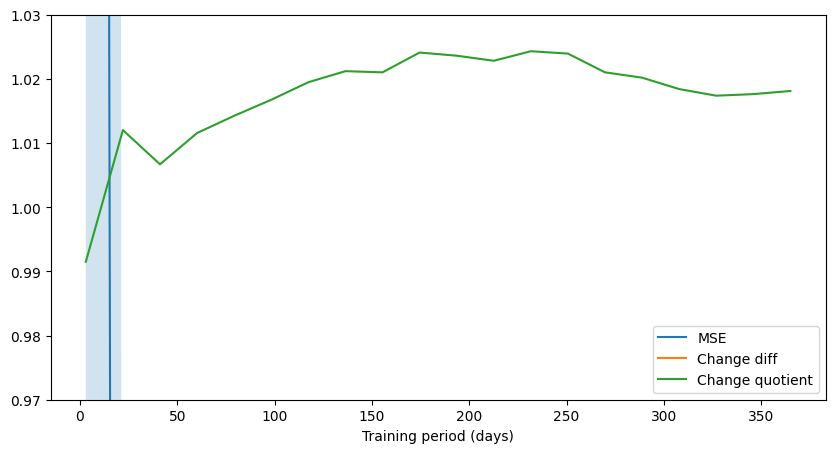

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["n_days_train"], df["mean_mse"], label="MSE")
ax.fill_between(
    df["n_days_train"],
    df["mean_mse"] - df["std_mse"],
    df["mean_mse"] + df["std_mse"],
    alpha=0.2,
)
ax.set_xlabel("Training period (days)")
ax.plot(df["n_days_train"], df["change_diff"] / 14, label="Change diff")
ax.plot(df["n_days_train"], 1 / df["change_quotient"], label="Change quotient")
# ax.set_ylim(-0.7, 0.5)
# ax.set_ylim(-0.05, 0.15)
ax.set_ylim(0.97, 1.03)
ax.legend()

In [ ]:
data = []
for n_days_train in tqdm(range(3, 40, 2)):
    metrics, df, agg_df = evaluate_multiple_protests(
        "klima*",
        random_events,
        source="mediacloud",
        data_kwargs=dict(
            n_days_train=n_days_train,
            n_days_predict=7 * 2,
            n_days_protest_free_pre=0,
            n_days_protest_free_post=0,
            min_control_regions=1,
            min_count=3,
        ),
        method_kwargs=dict(
            method=predict_with_lasso,
        ),
    )
    data.append(
        {
            "n_days_train": n_days_train,
            "mean_mse": np.mean([m["mse"] for m in metrics]),
            "std_mse": np.std([m["mse"] for m in metrics]),
            "mean_change_diff": np.mean([m["change_diff"] for m in metrics]),
            "std_change_diff": np.std([m["change_diff"] for m in metrics]),
            "mean_change_quotient": np.mean([m["change_quotient"] for m in metrics]),
            "std_change_quotient": np.std([m["change_quotient"] for m in metrics]),
        }
    )
df = pd.DataFrame(data)

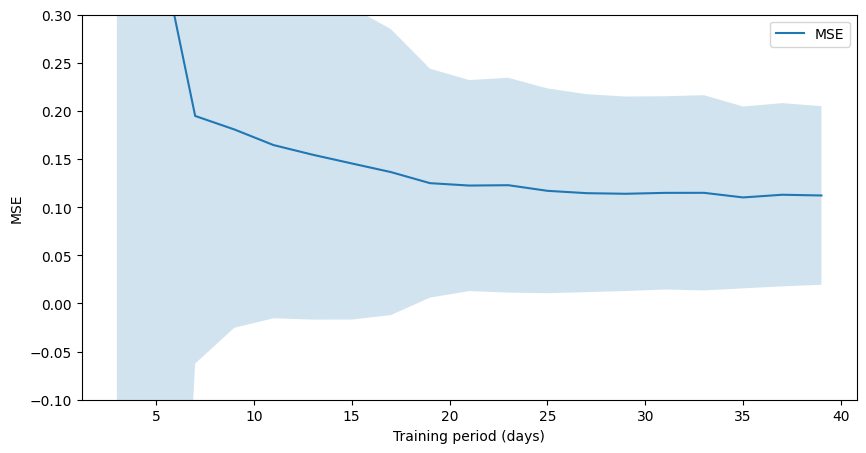

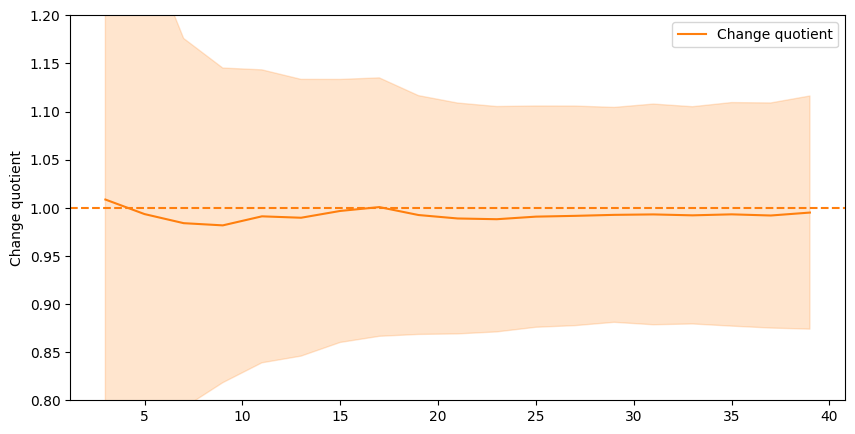

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["n_days_train"], df["mean_mse"], label="MSE")
ax.fill_between(
    df["n_days_train"],
    df["mean_mse"] - df["std_mse"],
    df["mean_mse"] + df["std_mse"],
    alpha=0.2,
)
ax.legend()
ax.set_xlabel("Training period (days)")
ax.set_ylabel("MSE")
ax.set_ylim(-0.1, 0.3)
plt.show()

fig, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(
    df["n_days_train"], df["mean_change_quotient"], label="Change quotient", color="C1"
)
ax2.fill_between(
    df["n_days_train"],
    df["mean_change_quotient"] - df["std_change_quotient"],
    df["mean_change_quotient"] + df["std_change_quotient"],
    alpha=0.2,
    color="C1",
)
ax2.set_ylim(0.8, 1.2)
ax2.set_ylabel("Change quotient")
# horizontal line at 1
ax2.axhline(1, color="C1", linestyle="--")
ax2.legend()
plt.show()